In [1]:
# Francisco Dominguez Mateos
# 03/08/2020
# SIREN for SDF in 2D
# added loss_sdf that is SIREN loss for sdf
# from:https://www.youtube.com/watch?v=Q5g3p9Zwjrk
#      https://vsitzmann.github.io/siren/

In [2]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jacrev, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax
from jax.experimental import optimizers

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cv2
print("OpenCV v",cv2.__version__)

OpenCV v 4.3.0


In [3]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(1)

In [4]:
def Siren(s=[1000]*5,omega_0=30.0):
    def init_fun(key,input_shape):
        """ Initialize the weights of all layers of a linear layer network """
        sizes=[input_shape[-1]]+s
        print(sizes)
        keys = random.split(key, len(sizes))
        print(len(keys))
        # Initialize a single layer with Gaussian weights -  helper function
        def initialize_layer(m, n, rng):
            scale=np.sqrt(6.0/float(m))/omega_0
            w_key, b_key = random.split(rng)
            return scale * random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        # actually they are pairs plus the random key
        pairs=list(zip(sizes[:-1], sizes[1:], keys))
        params=[initialize_layer(m, n, k) for m, n, k in pairs[:]]
        # First layes scale is different
        m,n,k=pairs[0]
        w_key, b_key = random.split(k)
        scale=1.0/float(m)
        print("scale",m,n,scale)
        params[0]=scale*random.uniform(w_key, (n, m),minval=-1.0, maxval=1.0),scale * random.uniform(b_key, (n,  ),minval=-1.0, maxval=1.0)
        output_shape =  input_shape[:-1] + (sizes[-1],)
        return (output_shape,params)
    def apply_fun(params, inputs, **kwargs):
        """ Compute the forward pass for each example individually """
        activations = inputs
        # Loop over the Siren hidden layers
        for w, b in params[:-1]:
            linear = np.dot(w,activations)+b
            activations=np.sin(omega_0*linear)
        #not activation function in last layer
        w,b=params[-1]
        linear= np.dot(w,activations)+b
        #return activations#.reshape(())
        return linear#.reshape(())
    return init_fun, apply_fun

In [5]:
# This function is needed because grad need a funtion with scalar as output, that is what a.reshape(()) does
# and Siren return a 1D np.array that grad doesn't like
def net_pre_grad(params,x):
    a=net(params,x)
    return a.reshape(())
def laplace(params,x):
    jac=jacrev(net_grad,1)
    return np.trace(jac(params,x))

In [142]:
#
#                     I n i t   S I R E N
#
init,net=Siren([256]*3+[1])
net_grad=grad(net_pre_grad,argnums=1)
net_lapl=laplace

input_shape=(-1,2)
output_shape,params=init(rng,input_shape)
print(output_shape)
for l in params:
    print(l[0].shape,l[1].shape)

[2, 256, 256, 256, 1]
5
scale 2 256 0.5
(-1, 1)
(256, 2) (256,)
(256, 256) (256,)
(256, 256) (256,)
(1, 256) (1,)


In [7]:
net(params,np.array([0.5,0.5]))

DeviceArray([-0.0189982], dtype=float32)

In [8]:
net_grad(params,np.array([0.5,0.5]))

DeviceArray([-0.13924393, -0.09143916], dtype=float32)

In [9]:
# Make a batched version of the `net` function
batch_net      = vmap(net     , in_axes=(None, 0), out_axes=0)
batch_net_grad = vmap(net_grad, in_axes=(None, 0), out_axes=0)
batch_net_lapl = vmap(net_lapl, in_axes=(None, 0), out_axes=0)

In [10]:
def getInputOrdered(size):
    width=size[1]
    height=size[0]
    X, Y = np.meshgrid(range(height),range(width))
    X=X/height*2.0-1.0
    Y=Y/width *2.0-1.0
    xy=np.dstack((Y,X))
    input_ordered=np.reshape(xy,(-1,2))
    return input_ordered

def build_sdf(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width))

def build_sdf_grad(size):
    width=size[1]
    height=size[0]
    input_ordered=getInputOrdered(size)
    print(input_ordered.shape)

    img=batch_net_grad(params,input_ordered)
    print(img.shape)
    return np.reshape(img,(height,width,2))

In [11]:
def getImgGrads(gsdf_values_gt):
    #print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    gmax=np.max(gsdf_values_gt)
    gmin=np.min(gsdf_values_gt)
    d=gmax-gmin
    gsdf_values_gt/=d
    #print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    gsdf_values_gt-=np.min(gsdf_values_gt)
    #norms=np.linalg.norm(gsdf_values_gt,axis=1).reshape(-1,1)+0.0001
    #print("norms",norms.shape)
    #gsdf_values=gsdf_values_gt/norms
    #print(np.max(gsdf_values_gt),np.min(gsdf_values_gt))
    z=np.zeros((gsdf_values_gt.shape[0],1))
    v=np.hstack((gsdf_values_gt,z))
    img=np.reshape(v,(H,W,3))
    return img

In [12]:
sidelength=256

(65536, 2)
(65536, 1)
0.08095692 -0.07870435


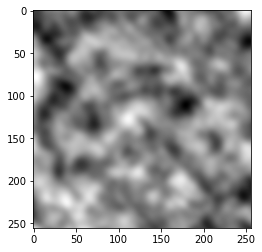

In [13]:
W=sidelength
H=sidelength
input_ordered=getInputOrdered((H,W))
img=build_sdf((H,W))
print(np.max(img),np.min(img))
plt.imshow((img+1.0)/2.0,cmap='gray',)

In [14]:
input_ordered=getInputOrdered((H,W))
img=build_sdf_grad((H,W))
print(np.max(img),np.min(img))

(65536, 2)
(65536, 2)
1.2299024 -1.056853


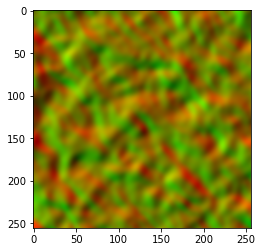

In [15]:
net_grads=img.reshape((-1,2))
img_grads=getImgGrads(net_grads)
plt.imshow(img_grads)

In [16]:
@jit
def sdf_2d(point):
    x,y=point
    d0=x*x+y*y-0.30*0.30
    x1=x+0.3
    y1=y-0.3
    d1=x1*x1+y1*y1-0.15*0.15
    x2=x+0.3
    y2=y+0.3
    d2=x2*x2+y2*y2-0.15*0.15
    return np.min(np.array([d0,d1,d2]))
def points():
    pts=[]
    pts+=pointsCircle(0.0, 0.0,0.30)
    pts+=pointsCircle(0.3,-0.3,0.15)
    pts+=pointsCircle(0.3, 0.3,0.15)
    
gsdf_2d=grad(sdf_2d)

print( sdf_2d((0.2,0.2)))
print(gsdf_2d((0.2,0.2)))
#batch_sdf_2d =vmap( sdf_2d, in_axes=(None, 0), out_axes=0)
#batch_gsdf_2d=vmap(gsdf_2d, in_axes=(None, 0), out_axes=0)
batch_sdf_2d =vmap( sdf_2d)
batch_gsdf_2d=vmap(gsdf_2d)

-0.009999998
(DeviceArray(0.4, dtype=float32), DeviceArray(0.4, dtype=float32))


In [17]:
#mapped=list(map(sdf_2d,input_ordered))
mapped=batch_sdf_2d(input_ordered)
sdf_values=np.reshape(np.array(mapped),(-1,1))
print(sdf_values.shape)
s=np.max(sdf_values)-np.min(sdf_values)
sdf_values/=s
print(np.max(sdf_values),np.min(sdf_values))

(65536, 1)
0.95464706 -0.045352936


In [18]:
#gmapped=list(map(gsdf_2d,input_ordered))    
gmapped=batch_gsdf_2d(input_ordered)    
gsdf_values=np.reshape(np.array(gmapped),(-1,2))
print(gsdf_values.shape)

(65536, 2)


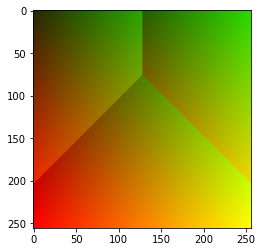

In [19]:
img=getImgGrads(gsdf_values)
plt.imshow(img)

(65536, 1)


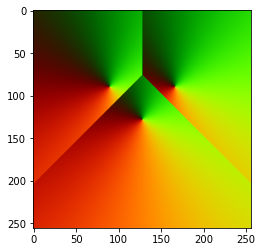

In [20]:
gsdf_norms=np.linalg.norm(gsdf_values,axis=1).reshape(-1,1)+0.0001
print(gsdf_norms.shape)
gsdf_norm=gsdf_values/gsdf_norms
img=getImgGrads(gsdf_norm)
plt.imshow(img)

sdf_max 0.95464706
sdf_min -0.045352936


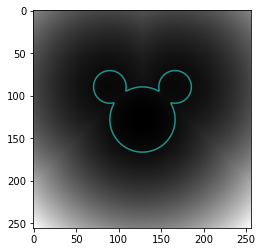

In [21]:
def drawContour(sdf_values):    
    img=np.reshape(sdf_values,(H,W))
    sdf_max=np.max(sdf_values)
    sdf_min=np.min(sdf_values)
    print("sdf_max",sdf_max)
    print("sdf_min",sdf_min)
    plt.imshow((img+1.0)/2.0,cmap="gray")
    cs=plt.contour(range(H),range(W),img,0)
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()
drawContour(sdf_values)

In [22]:
print("input_ordered" ,input_ordered.shape)
print("sdf_values" ,sdf_values.shape)
print("gsdf_values",gsdf_values.shape)

idxb=np.abs(sdf_values)<0.001
idx0=np.where(idxb)[0]
print("idx0",idx0.shape)

points_insurface =input_ordered[idx0]
values_insurface =sdf_values[idx0]
normals_insurface=gsdf_norms[idx0]
labels_insurface =np.ones(values_insurface.shape)
print("points_insurface" ,points_insurface.shape)
print("values_insurface" ,values_insurface.shape)
print("normals_insurface",normals_insurface.shape)

idxb=np.logical_not(idxb)
idx1=np.where(idxb)[0]
print("idx1",idx1.shape)
points_outsurface_all =input_ordered[idx1]
values_outsurface_all =sdf_values[idx1]
normals_outsurface_all=gsdf_norms[idx1]

N=points_insurface.shape[0]

targets=np.hstack((values_insurface,normals_insurface))
inputs=points_insurface
print(targets.shape)
print(inputs.shape)

input_ordered (65536, 2)
sdf_values (65536, 1)
gsdf_values (65536, 2)
idx0 (536,)
points_insurface (536, 2)
values_insurface (536, 1)
normals_insurface (536, 1)
idx1 (65000,)
(536, 2)
(536, 2)


In [110]:
def buildData():
    global rng
    rng, rng_input = random.split(rng)
    idx=random.permutation(rng,idx1)
    #print("idx1",idx1.shape)
    #print("idx",idx.shape)
    idxN=idx[:N]
    points_outsurface =points_outsurface_all[idxN]
    points_outsurface=random.uniform(rng,points_outsurface.shape)*2.0-1.0
    values_outsurface =values_outsurface_all[idxN]
    normals_outsurface=normals_outsurface_all[idxN]
    labels_outsurface =np.zeros(values_outsurface.shape)
    #print("points_outsurface" ,points_outsurface.shape)
    #print("values_outsurface" ,values_outsurface.shape)
    #print("normals_outsurface",normals_outsurface.shape)
    #print("labels_outsurface",labels_outsurface.shape)

    x=np.vstack((points_insurface ,points_outsurface))
    v=np.vstack((values_insurface ,values_outsurface))
    n=np.vstack((normals_insurface,normals_outsurface))
    l=np.vstack((labels_insurface ,labels_outsurface))
    #print("x" ,x.shape)
    #print("v" ,v.shape)
    #print("n",n.shape)

    inputs=x
    targets=np.hstack((v,n,l))
    #print(inputs.shape)
    #print(targets.shape)    
    return inputs,targets
inputs,targets=buildData()
print(inputs.shape)
print(targets.shape)    


(1072, 2)
(1072, 3)


$$L_\Omega=\lambda_1\sum_{\Omega}|1-||\nabla\phi(x)||_2|+\sum_{\Omega_0}\lambda_2|\phi(x)|+\lambda_3|1-\nabla\phi(x)\cdot n(x)|+\lambda_3\sum_{\Omega-\Omega_0}\psi(x)$$

$$\psi(\phi(x))=e^{-\alpha |\phi(x)|}\;\;\;\alpha>>1$$

In [143]:
@jit
def loss_sdf_easy(params,inputs,targets):
    #hyper params valuesfrom paper
    #constraint gradient=1
    λ1=5e1
    # off-surface penalization and sdf constraint
    λ2=3e6
    # oriented surface normal constraint
    λ3=1e2
    values,normals,labels=targets[:,0],targets[:,1:3],targets[:,3]
    #print("values",values.shape)
    #print("labels",labels.shape)
    
    Φ      = batch_net     (params, inputs)
    Φ_abs  = np.abs(Φ)
    #print("phi",phi.shape)
    Φ_grad = batch_net_grad(params,inputs)
    Φ_grad_norm=np.linalg.norm(Φ_grad,axis=1)

    #loss_d=(phi-values)**2
    loss_d=Φ_abs#-values)**2
    #loss_d=phi**2
    #loss_n=np.linalg.norm(phi_grad-normals,axis=1)
    #loss_n=(1-np.sum(phi_grad*normals,axis=1))**2
    #cosine similarity given that we have unit normals
    loss_n=np.abs(1-np.sum(Φ_grad*normals,axis=1)/Φ_grad_norm)
    loss_in =λ2*loss_d+λ2*loss_n

    α=100.0
    ψ=np.exp(-α*Φ_abs)
    loss_out=λ3*ψ#(λ1*loss_norm1+λ2*ψ)

    #loss_norm1=(1-np.linalg.norm(phi_grad,axis=1))**2
    loss_norm1=np.abs(1-Φ_grad_norm)

    loss=λ1*loss_norm1+labels*loss_in+(1.0-labels)*loss_out
    return np.mean(loss)

In [144]:
@jit
def accuracy(params,inputs,targets):
    return loss_sdf_easy(params,inputs,targets)
@jit
def update(params, x, y, opt_state):
    #print("y=",len(y))
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss_sdf_easy)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [145]:
#gsdf_norms=np.linalg.norm(gsdf_values,axis=1).reshape(-1,1)+0.0001
#print(gsdf_norms.shape)
#gsdf_norm=gsdf_values/gsdf_norms
#targets=np.hstack((sdf_values,gsdf_norm))
#print(sdf_values.shape)
#print(gsdf_values.shape)
#print(gsdf_norm.shape)
#print(targets.shape)
#print(input_ordered.shape)
#inputs=input_ordered.copy()
#loss_sdf_easy(params,input_ordered,targets)

In [146]:
#
#                                        Defining an optimizer in Jax
#
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [147]:
num_epochs = 10000
steps_til_summary = num_epochs/10

In [148]:
def drawPred(plt,img_pred,inputs):
    img=img_pred.reshape((sidelength,sidelength))
    minp=np.min(img)
    maxp=np.max(img)
    print(maxp,minp)
    plt.imshow(img)
    cs=plt.contour(range(H),range(W),img,np.linspace(minp,0.0,2))
    cs.cmap.set_over('red')
    cs.cmap.set_under('blue')
    cs.changed()
    #plt.scatter(inputs[:,1]*sidelength/2+sidelength/2,inputs[:,0]*sidelength/2+sidelength/2,color=colors[targets[:,3].astype("int")])    

In [149]:
def shuffle_data(x,y):
    #idx=random.randint(rng,x.shape[0],0,x.shape[0])
    #idx=onp.random.randint(0,x.shape[0])
    idx=random.shuffle(rng,np.arange(x.shape[0]))
    return x[idx],y[idx]
def run_training_loop(num_epochs, opt_state):
    global params
    #inputs,targets=buildData()
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        inputs,targets=buildData()
        i,t=shuffle_data(inputs,targets)
        params, opt_state, loss = update(params, i,t, opt_state)
        train_loss.append(loss)

        if(epoch %steps_til_summary ==0):
            epoch_time = time.time() - start_time
            print("Epoch {} | T: {:0.3f} | loss: {:0.4f}".format(epoch+1, epoch_time,loss))
            img_pred =batch_net(params,input_ordered)
            img_grad =batch_net_grad(params,input_ordered)
            img_lapl =batch_net_lapl(params,input_ordered)
            
            fig, axes = plt.subplots(1,3, figsize=(18,6))
            #axes[0].imshow(img_pred.reshape((sidelength,sidelength)))
            drawPred(axes[0],img_pred,inputs)
            #axes[1].imshow(np.linalg.norm(img_grad,axis=1).reshape((sidelength,sidelength)))
            axes[1].imshow(getImgGrads(img_grad))
            axes[2].imshow(img_lapl.reshape((sidelength,sidelength)))
            plt.show()
    epoch_time = time.time() - start_time
    print("Epoch {} | T: {:0.3f} | loss: {:0.4f}".format(epoch+1, epoch_time,loss))
    img_pred =batch_net(params,input_ordered)
    img_grad =batch_net_grad(params,input_ordered)
    img_lapl =batch_net_lapl(params,input_ordered)

    fig, axes = plt.subplots(1,3, figsize=(18,6))
    #axes[0].imshow(img_pred.reshape((sidelength,sidelength)))
    drawPred(axes[0],img_pred,inputs)
    #axes[1].imshow(np.linalg.norm(img_grad,axis=1).reshape((sidelength,sidelength)))
    axes[1].imshow(getImgGrads(img_grad))
    axes[2].imshow(img_lapl.reshape((sidelength,sidelength)))
    plt.show()

    return opt_state, train_loss, log_acc_train, log_acc_test

Epoch 1 | T: 1.717 | loss: 1451867.8750
0.16950671 -0.17495619


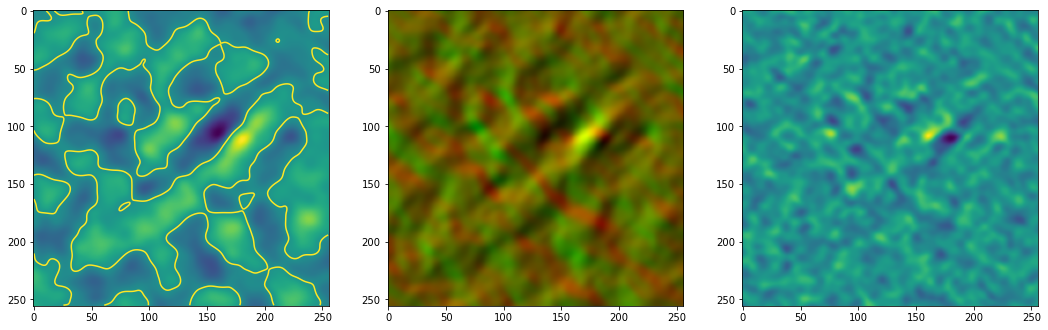

Epoch 1001 | T: 0.014 | loss: 15469.9980
0.0124668395 -0.012751501


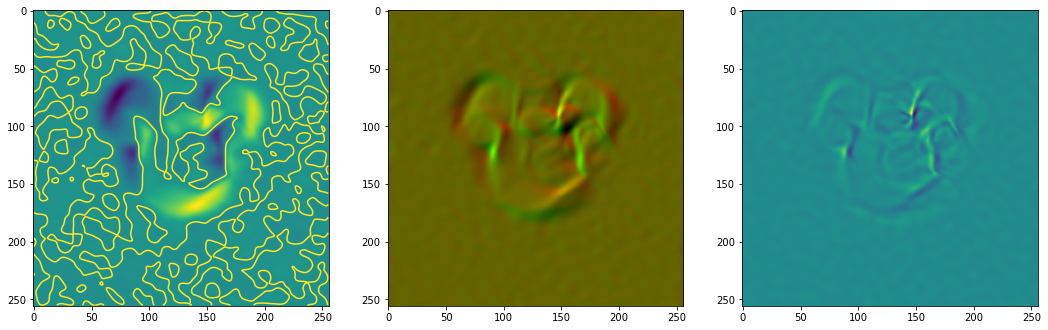

Epoch 2001 | T: 0.015 | loss: 11729.1377
0.008654583 -0.008651056


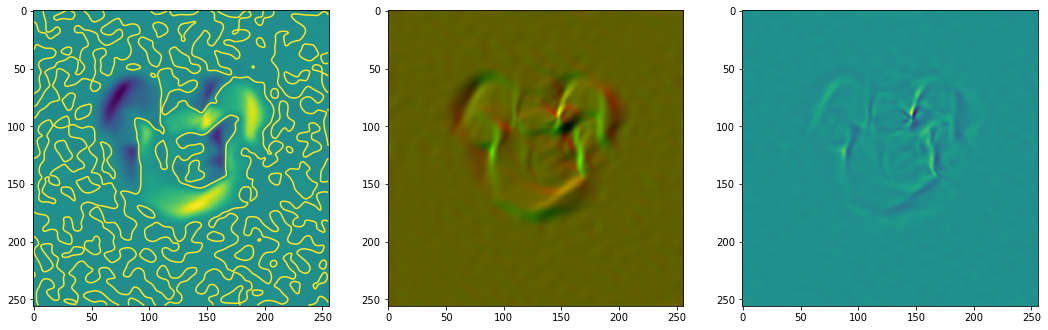

Epoch 3001 | T: 0.015 | loss: 8064.6709
0.007156374 -0.0069168922


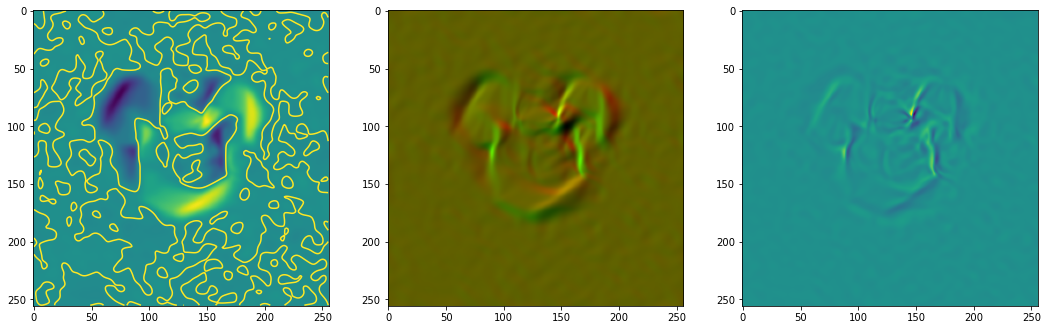

Epoch 4001 | T: 0.015 | loss: 7633.9912
0.006043764 -0.005736172


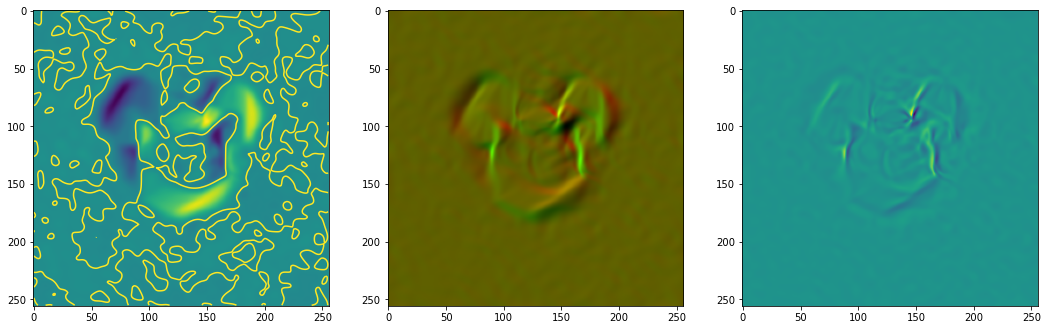

Epoch 5001 | T: 0.014 | loss: 6775.6606
0.005313799 -0.0049246997


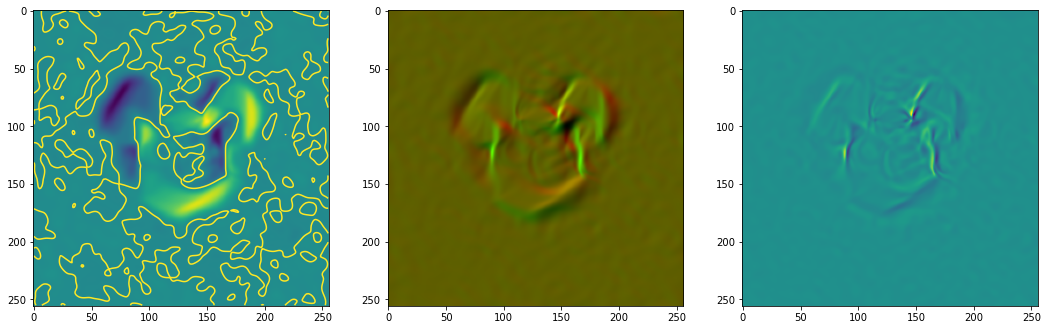

Epoch 6001 | T: 0.015 | loss: 6950.3262
0.00497471 -0.0044769505


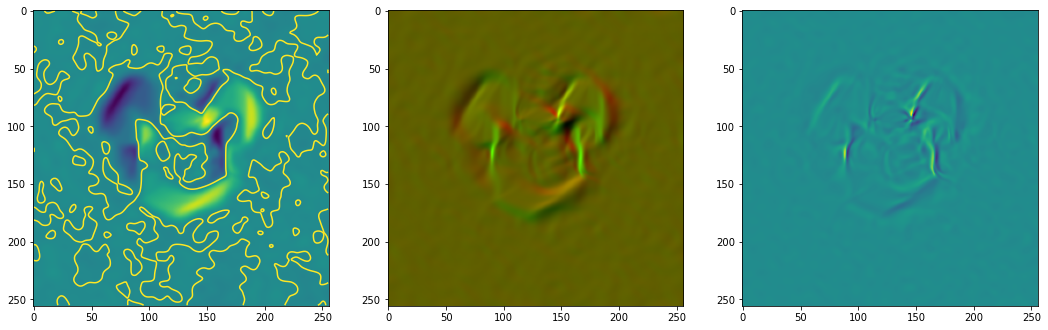

Epoch 7001 | T: 0.016 | loss: 6213.5063
0.0050634663 -0.0043659527


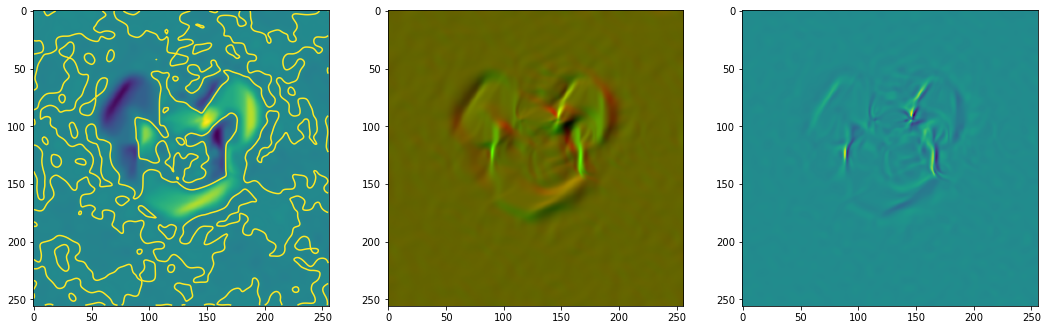

Epoch 8001 | T: 0.015 | loss: 6641.2896
0.006843421 -0.005930879


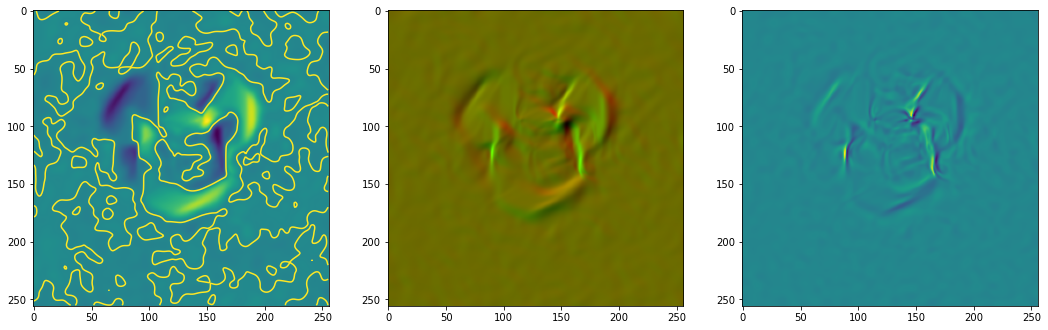

Epoch 9001 | T: 0.016 | loss: 5932.5898
0.005242285 -0.0045161075


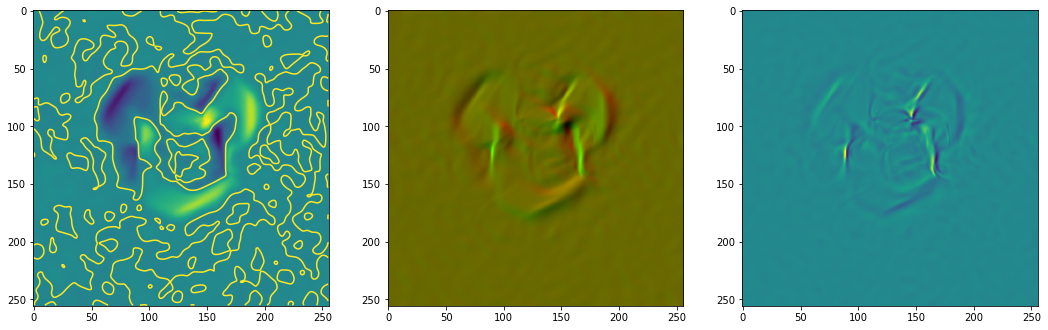

Epoch 10000 | T: 0.015 | loss: 5406.3765
0.004621675 -0.004234708


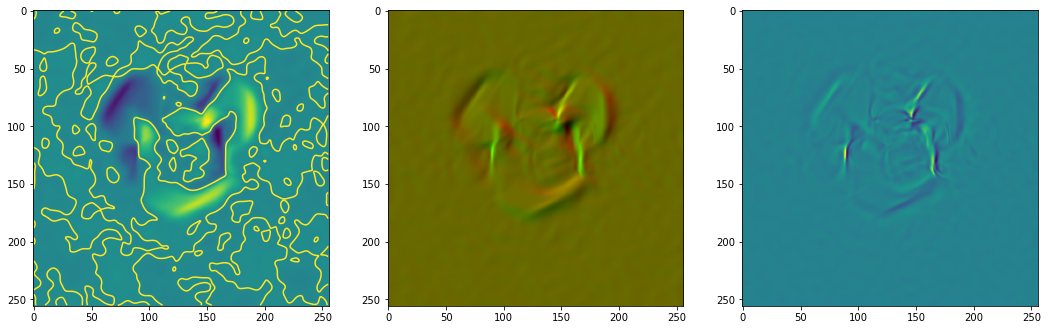

In [150]:
opt_state, train_loss, train_log, test_log =run_training_loop(num_epochs,opt_state)

In [151]:
loss_sdf_easy(params,inputs,targets)

DeviceArray(5289.661, dtype=float32)

(65536, 2)
(65536, 1)
-0.004234708 0.004621675


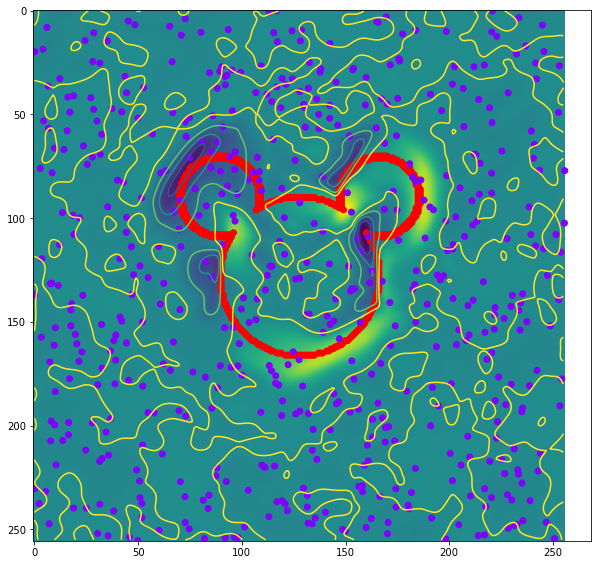

In [152]:
plt.figure(figsize=(10,10))
colors = cm.rainbow(np.linspace(0, 1, 2))
img=build_sdf((H,W))
minp=np.min(img)
maxp=np.max(img)
print(np.min(img),np.max(img))
plt.imshow((img+1.0)/2.0)#,cmap="gray")
cs=plt.contour(range(H),range(W),img,np.linspace(minp,0.0,5))
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()
plt.scatter(inputs[:,1]*sidelength/2+sidelength/2,inputs[:,0]*sidelength/2+sidelength/2,color=colors[targets[:,3].astype("int")])

(65536, 2)
(65536, 1)
-0.004234708 0.004621675


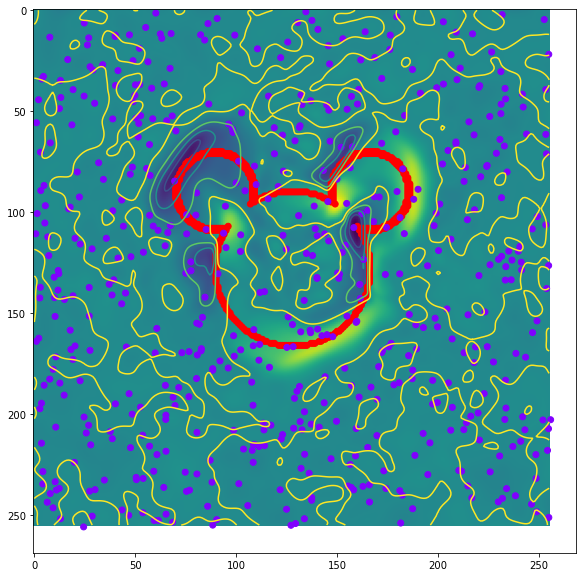

In [153]:
inputs,targets=buildData()
plt.figure(figsize=(10,10))
colors = cm.rainbow(np.linspace(0, 1, 2))
img=build_sdf((H,W))
minp=np.min(img)
maxp=np.max(img)
print(np.min(img),np.max(img))
plt.imshow((img+1.0)/2.0)#,cmap="gray")
cs=plt.contour(range(H),range(W),img,np.linspace(minp,0.0,5))
cs.cmap.set_over('red')
cs.cmap.set_under('blue')
cs.changed()
plt.scatter(inputs[:,1]*sidelength/2+sidelength/2,inputs[:,0]*sidelength/2+sidelength/2,color=colors[targets[:,3].astype("int")])

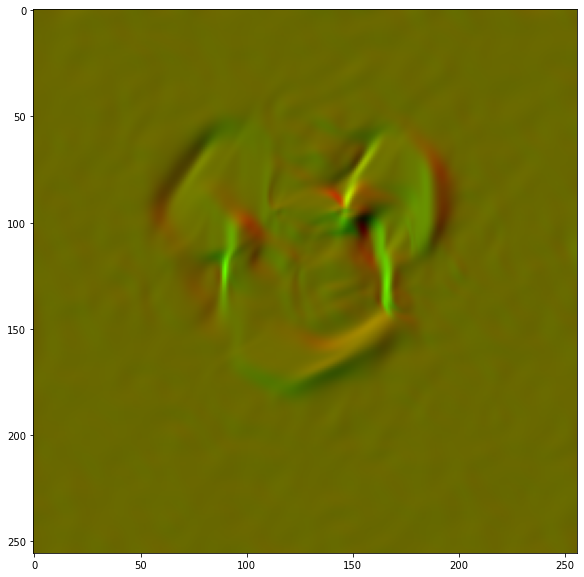

In [154]:
plt.figure(figsize=(10,10))
img_grad =batch_net_grad(params,input_ordered)
img=getImgGrads(img_grad)
plt.imshow(img)

In [132]:
net(params,np.array([0,0]))

DeviceArray([-0.01165967], dtype=float32)

In [39]:
net_grad(params,np.array([0.0,0.0]))

DeviceArray([-0.00494281,  0.00041988], dtype=float32)

In [35]:
(net(params,np.array([0.00001,0]))-net(params,np.array([0.,0])))/0.00001

DeviceArray([69.30232], dtype=float32)

In [36]:
(net(params,np.array([0.0,0.00001]))-net(params,np.array([0.0,0.0])))/0.00001

DeviceArray([59.568882], dtype=float32)